# Subscribers predictio V3

In [3]:
import math
import datetime
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
pd.options.display.float_format = '{:.2f}'.format

# Importing channel stats
Channel stats contains ~1 lakh records of Indian channels and their public stats

In [6]:
os.chdir(r"C:\Users\Acharya\Downloads\subscriber prediction-20200420T110746Z-001\subscriber prediction")
ch_stats=pd.read_csv("ch_stats_old.csv", sep="\t")
ch_stats.columns

Index(['Unnamed: 0', 'Channel ID', 'Views', 'Subscribers', 'Uploads',
       'Channel Creation Date'],
      dtype='object')

In [7]:
ch_stats=ch_stats[['Channel ID', 'Views', 'Subscribers', 'Uploads', 'Channel Creation Date']]
ch_stats=ch_stats[ch_stats['Channel ID'].notnull()]
ch_stats.reset_index(inplace=True)

# Importing channel last 30 days stats (video level data)
Last 30 days stats contains views, engagement, duration of the videos in last 30 days per channel

In [8]:
ch_30_stats=pd.read_csv("ch_30_stats1.csv", "\t")
ch_30_stats.columns
final_data=pd.merge(ch_stats, ch_30_stats, left_on="Channel ID", right_on="channelid", how="left")
final_data=final_data[['Channel ID', 'Views', 'Subscribers', 'Uploads',
       'Channel Creation Date', 'views', 'likes',
       'dislikes', 'comments', 'duration']]
final_data.rename(columns={'views':'views_30', 'likes':'likes_30', 'dislikes':'dislikes_30', 'comments':'comments_30', 'duration':'duration_30'}, inplace=True)
final_data.columns
final_data.isna().any()
final_data.fillna(0, inplace=True)
final_data['Channel Creation Date']=final_data['Channel Creation Date'].str.split("T", expand=True)[0]
final_data["Channel Creation Date"] = final_data["Channel Creation Date"].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')).date() if x is not None else None)
date_added = pd.Timestamp(datetime.date(2020, 1, 22)).replace(hour=0, minute=0, second=0, microsecond=0)
#final_data['date_added']=final_data['date_added'].astype(str).str.split(" ", expand=True)[0]
#final_data["date_added"]=pd.to_datetime(final_data["date_added"], format='%Y-%m-%d')
final_data['Channel Creation Date']=pd.to_datetime(final_data["Channel Creation Date"], format='%Y-%m-%d')
final_data["age_ch"]=date_added-final_data['Channel Creation Date']
final_data["age_ch"]=final_data["age_ch"].map(lambda x:x.days)    

# Deriving appropriate features

In [9]:
final_data["Views/day"]=final_data["Views"]/final_data["age_ch"]
final_data["Uploads/day"]=final_data["Uploads"]/final_data["age_ch"]
final_data["Views/Uploads"]=final_data["Views"]/final_data["Uploads"]

# Importing playlist level data
No of playlist present per channel

In [10]:
play_list=pd.read_csv("playlist_data.csv")
final_data=pd.merge(final_data, play_list, left_on="Channel ID", right_on='Channel ID', how='left')
final_data.columns


Index(['Channel ID', 'Views', 'Subscribers', 'Uploads',
       'Channel Creation Date', 'views_30', 'likes_30', 'dislikes_30',
       'comments_30', 'duration_30', 'age_ch', 'Views/day', 'Uploads/day',
       'Views/Uploads', 'Unnamed: 0', 'playlist_count'],
      dtype='object')

In [11]:
final_data_mod=final_data[['Channel ID', 'Views', 'Subscribers', 'Uploads',
       'Channel Creation Date', 'views_30', 'likes_30', 'dislikes_30',
       'comments_30', 'duration_30', 'age_ch', 'Views/day', 'Uploads/day', 'Views/Uploads','playlist_count']]

final_data_mod.columns
final_data_mod.replace([np.inf, -np.inf], np.nan, inplace=True)
final_data_mod.isna().any()

C:\Users\Acharya\Anaconda3\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Channel ID               False
Views                    False
Subscribers              False
Uploads                  False
Channel Creation Date    False
views_30                 False
likes_30                 False
dislikes_30              False
comments_30              False
duration_30              False
age_ch                   False
Views/day                False
Uploads/day              False
Views/Uploads             True
playlist_count           False
dtype: bool

In [12]:
def log_apply(df):
    return (df.apply(np.log))

In [13]:
final_data_mod1=final_data_mod[['Views', 'Uploads', 'views_30', 'likes_30', 'dislikes_30', 'comments_30', 'duration_30', 'age_ch', 'Views/day', 'Uploads/day', 'Views/Uploads', 'playlist_count', 'Subscribers']]
final_data_mod1.columns.values
final_data_mod1.dtypes
final_data_mod1.isna().any()
for column in final_data_mod1:
    final_data_mod1[column]=pd.to_numeric(final_data_mod1[column], downcast="integer")

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Deriving appropriate features

In [14]:
final_data_mod1['channel_views_per_day'] = final_data_mod1['Views']/((final_data_mod1['age_ch']*final_data_mod1['Uploads'])+1)

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
final_data_mod1['user_activity'] = final_data_mod1['likes_30']+0.5*final_data_mod1['dislikes_30']+5*final_data_mod1['comments_30']

In [16]:
final_data_mod1['vcbyua']=final_data_mod1['views_30']/(final_data_mod1['user_activity']+1)

In [17]:
final_data_mod1['positive_user_activity'] = final_data_mod1['likes_30']-final_data_mod1['dislikes_30']

In [18]:
final_data_mod1['relative_user_activity'] = (final_data_mod1['likes_30']+1)/(final_data_mod1['dislikes_30']+1)

In [19]:
final_data_mod1['Avg_channel_view_count']=final_data_mod1['Views']/(final_data_mod1['Uploads']+1)

In [20]:
final_data_mod1['relative_viewCount']=final_data_mod1['Views']-final_data_mod1['Avg_channel_view_count']


## Drawing correlations

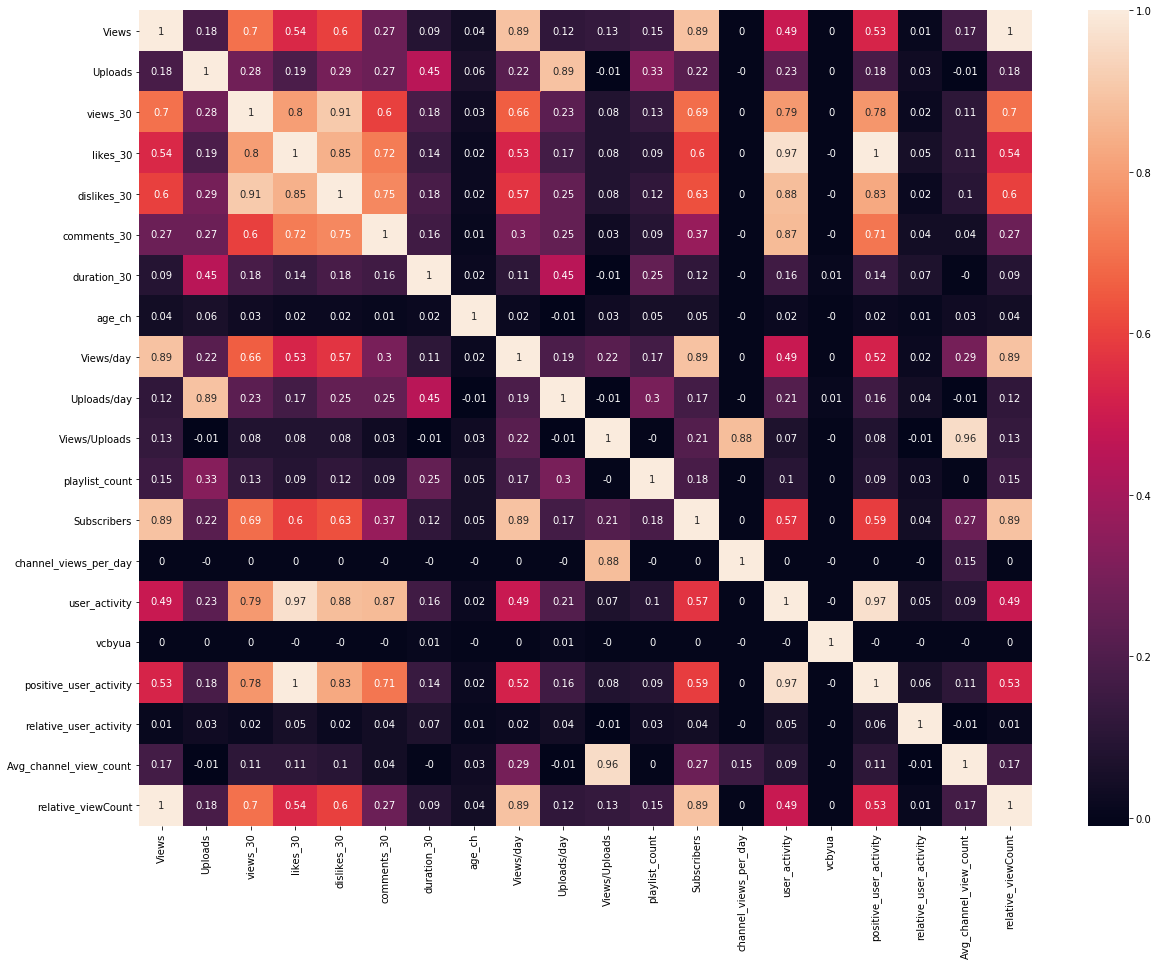

In [21]:
plt.subplots(figsize=(20,15))
correlation_matrix = final_data_mod1.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [22]:
final_data_mod1.to_csv("subscribers_data.csv")

In [23]:
def scaler(x):
    return((x-min(x))/(max(x)-min(x))).astype(float)

### Dropped variables which has less correlations with subscribers feature

In [24]:
drop=['age_ch', 'channel_views_per_day', 'vcbyua', 'relative_user_activity', 'Avg_channel_view_count','Uploads/day', 'playlist_count', 'Views/Uploads', 'duration_30', 'Uploads' , 'comments_30']

In [25]:
set(final_data_mod1)-set(drop)

{'Subscribers',
 'Views',
 'Views/day',
 'dislikes_30',
 'likes_30',
 'positive_user_activity',
 'relative_viewCount',
 'user_activity',
 'views_30'}

In [26]:
final_data_mod2=final_data_mod1[['Subscribers','Views', 'views_30', 'likes_30', 'dislikes_30', 'Views/day', 'user_activity', 'positive_user_activity', 'relative_viewCount']]

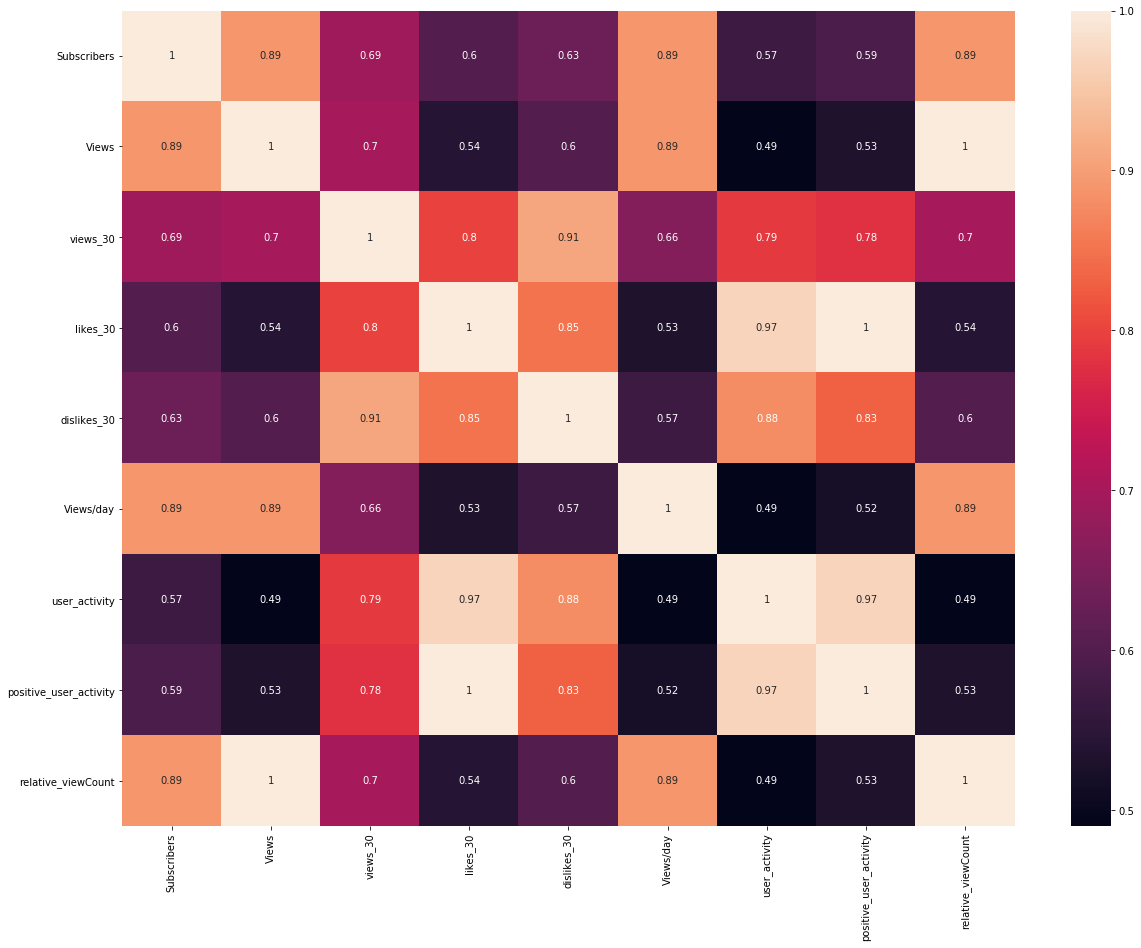

In [27]:
plt.subplots(figsize=(20,15))
correlation_matrix = final_data_mod2.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

### EDA
EDA reveals data contains lot of outliers and relationships among variables is very weak

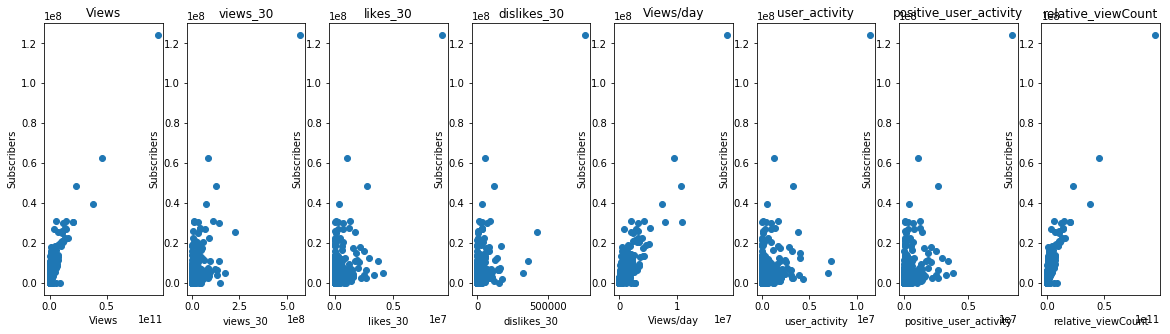

In [28]:
plt.figure(figsize=(20, 5))
features = final_data_mod2.drop('Subscribers', axis=1).columns
target = final_data_mod2['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = final_data_mod2[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Subscribers')

from yellowbrick.regressor import CooksDistance

X=final_data_mod2.drop(['Subscribers'],axis=1)

y=final_data_mod2['Subscribers']

visualizer = CooksDistance()
visualizer.fit(X['Views'].values.reshape(-1,1), y)
visualizer.show()

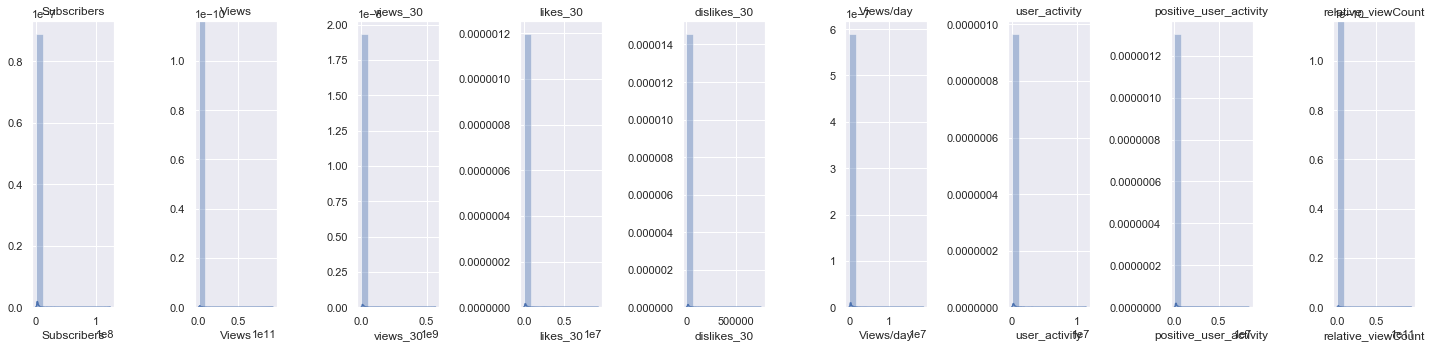

In [29]:
features = final_data_mod2.columns
sns.set(rc={'figure.figsize':(20,5)})
fig=plt.figure()
for i,col in enumerate(features):
    ax=fig.add_subplot(1, len(features) , i+1)
    sns.distplot(final_data_mod2[col], bins=11, ax=ax)
    plt.title(col)
fig.tight_layout()    
plt.show()


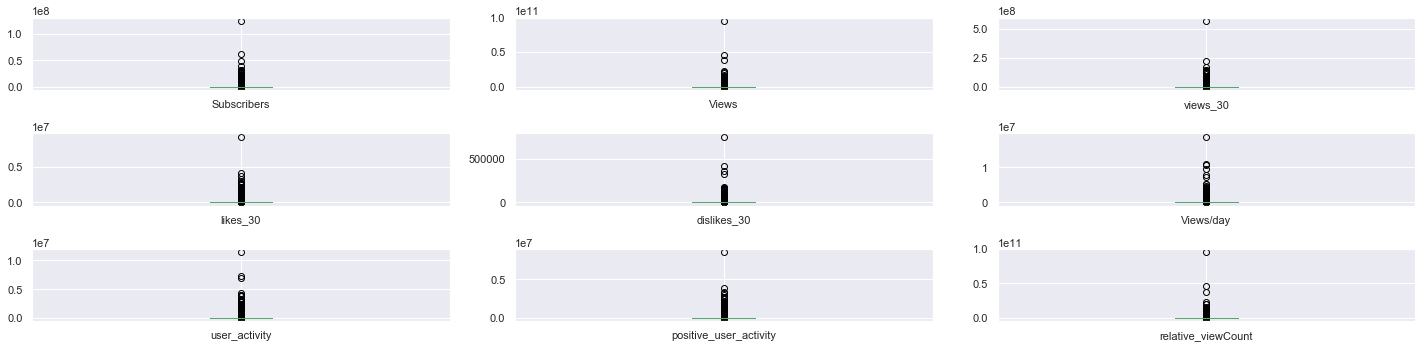

In [30]:
fig, axes = plt.subplots(3,3)
for i,col in enumerate(list(features)):
    a = final_data_mod2.boxplot(col,  ax=axes.flatten()[i])
# fig.delaxes(axes[1,1])
plt.tight_layout() 
plt.show()

In [31]:
final_data_mod2.describe()

,Subscribers,Views,views_30,likes_30,dislikes_30,Views/day,user_activity,positive_user_activity,relative_viewCount
count,119331.00,119331.00,119331.00,119331.00,119331.00,119331.00,119331.00,119331.00,119331.00
mean,79393.17,18254960.76,149677.33,3336.20,202.18,10045.85,4901.50,3134.02,18141973.13
std,676567.38,389402492.35,2695684.70,52273.12,3772.59,111789.28,74537.11,49105.90,389275850.78
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-6305.00,0.00
25%,2220.00,191075.00,0.00,0.00,0.00,129.90,0.00,0.00,181749.69
50%,6160.00,787632.00,0.00,0.00,0.00,534.29,0.00,0.00,757085.71
75%,24700.00,3467619.50,714.00,37.00,1.00,2434.30,74.00,34.00,3375074.05
max,124000000.00,94579583280.00,569440255.00,9197571.00,756422.00,18680541.83,11394847.00,8441149.00,94572959132.13


In [32]:
def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

In [33]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2['Subscribers'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2['Subscribers'], final)))
        

5 percentile is 0
10 percentile is 1190
15 percentile is 1510
20 percentile is 1840
25 percentile is 2220
30 percentile is 2680
35 percentile is 3270
40 percentile is 4000
45 percentile is 4950
50 percentile is 6160
55 percentile is 7800
60 percentile is 10000
65 percentile is 13100
70 percentile is 17700
75 percentile is 24700
80 percentile is 36800
85 percentile is 59400
90 percentile is 113000
95 percentile is 275000
100 percentile is 124000000


In [34]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2['Views'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2['Views'], final)))
        

5 percentile is 4129
10 percentile is 26061
15 percentile is 68976
20 percentile is 124941
25 percentile is 191075
30 percentile is 269624
35 percentile is 360425
40 percentile is 471887
45 percentile is 610341
50 percentile is 787632
55 percentile is 1020889
60 percentile is 1343983
65 percentile is 1782603
70 percentile is 2440798
75 percentile is 3467912
80 percentile is 5180615
85 percentile is 8415219
90 percentile is 15739839
95 percentile is 40716640
100 percentile is 94579583280


### quantile analysis for 5% and 95%

In [35]:
quantiles=final_data_mod2.quantile([0.05, 0.95])

In [36]:
quantiles

,Subscribers,Views,views_30,likes_30,dislikes_30,Views/day,user_activity,positive_user_activity,relative_viewCount
0.05,0.00,4129.00,0.00,0.00,0.00,3.32,0.00,0.00,3438.91
0.95,275000.00,40710899.50,175158.50,4273.50,239.00,29211.90,6844.75,3950.50,40135653.42


In [37]:
# final_data_mod2_capped=final_data_mod2[(final_data_mod2['Subscribers']>list(quantiles['Subscribers'])[0]) & (final_data_mod2['Subscribers']<list(quantiles['Subscribers'])[1])]

# Capped outliers
capping outliers at 5 and 95 didnot improve much of data quality

In [38]:
#capped outliers on views

In [39]:
final_data_mod2_capped=final_data_mod2[(final_data_mod2['Views']>list(quantiles['Views'])[0]) & (final_data_mod2['Views']<list(quantiles['Views'])[1])]

In [40]:
len(final_data_mod2)-len(final_data_mod2_capped)

11935

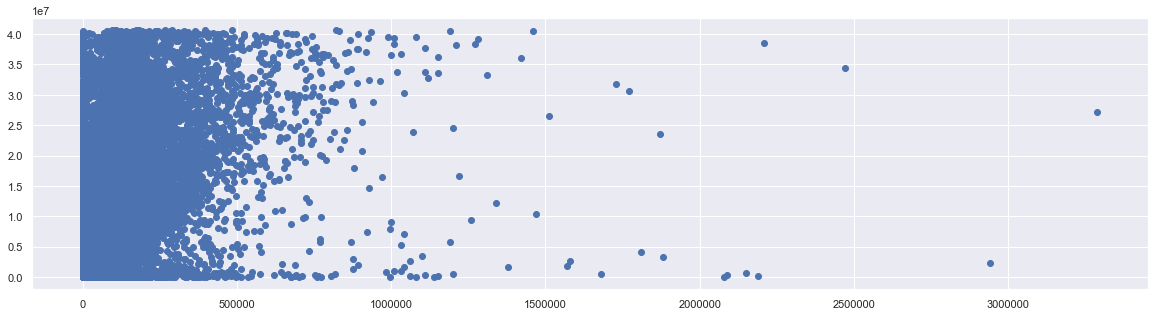

In [41]:
plt.scatter((final_data_mod2_capped['Subscribers']), (final_data_mod2_capped['Views']))

In [42]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Subscribers'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Subscribers'], final)))
        

5 percentile is 0
10 percentile is 1210
15 percentile is 1510
20 percentile is 1830
25 percentile is 2200
30 percentile is 2630
35 percentile is 3170
40 percentile is 3830
45 percentile is 4690
50 percentile is 5740
55 percentile is 7150
60 percentile is 9020
65 percentile is 11500
70 percentile is 15000
75 percentile is 20300
80 percentile is 28100
85 percentile is 41700
90 percentile is 66800
95 percentile is 128000
100 percentile is 3290000


In [43]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Views'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Views'], final)))
        

5 percentile is 22900
10 percentile is 59053
15 percentile is 107535
20 percentile is 163202
25 percentile is 228973
30 percentile is 303437
35 percentile is 391755
40 percentile is 497215
45 percentile is 626065
50 percentile is 787632
55 percentile is 994898
60 percentile is 1270729
65 percentile is 1631523
70 percentile is 2155253
75 percentile is 2900982
80 percentile is 4024573
85 percentile is 5930604
90 percentile is 9350626
95 percentile is 16876840
100 percentile is 40705159


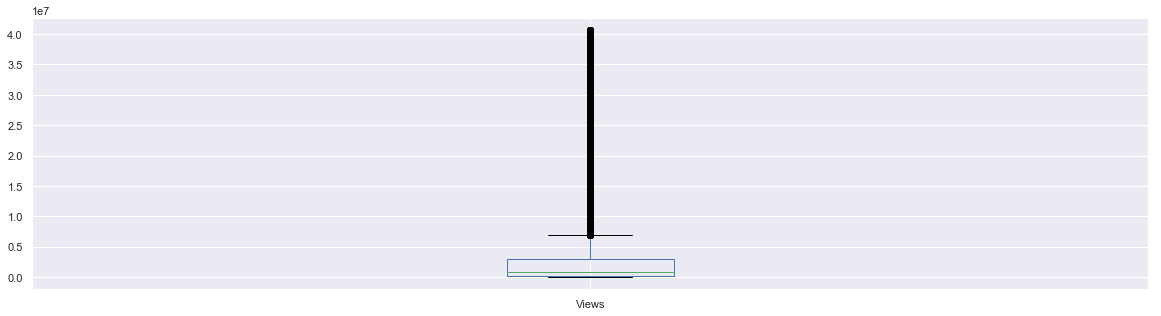

In [44]:
final_data_mod2_capped.boxplot('Views')
plt.show()

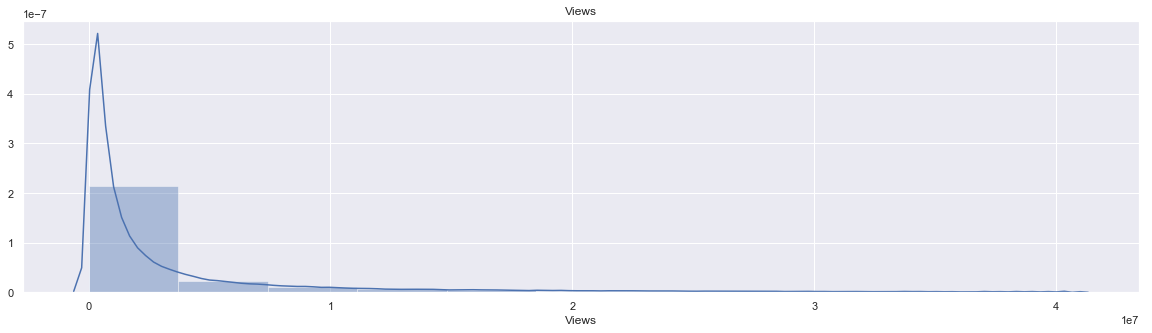

In [45]:
sns.distplot((final_data_mod2_capped['Views']), bins=11)
plt.title('Views')
# fig.tight_layout()    
plt.show()

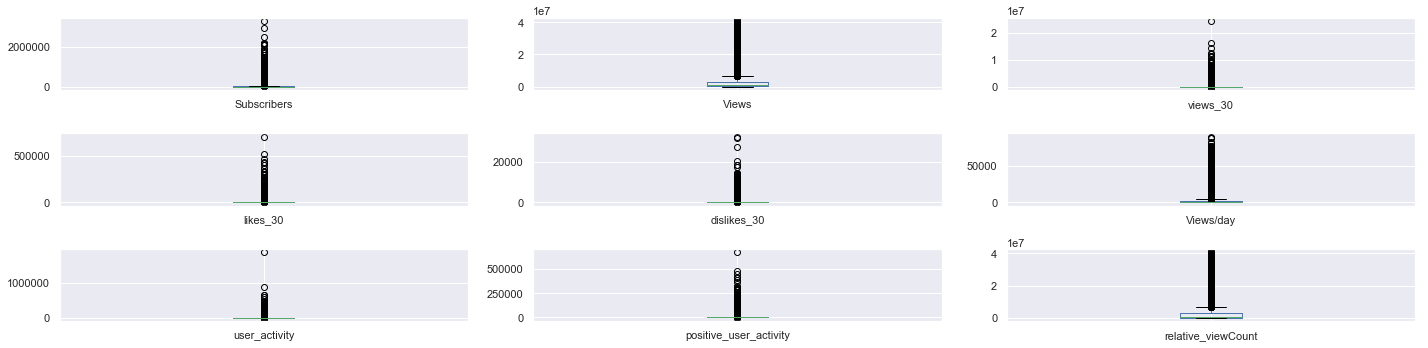

In [46]:
features=final_data_mod2_capped.columns
fig, axes = plt.subplots(3,3)
for i,col in enumerate(list(features)):
    a = final_data_mod2_capped.boxplot(col,  ax=axes.flatten()[i])
# fig.delaxes(axes[1,1])
plt.tight_layout() 
plt.show()

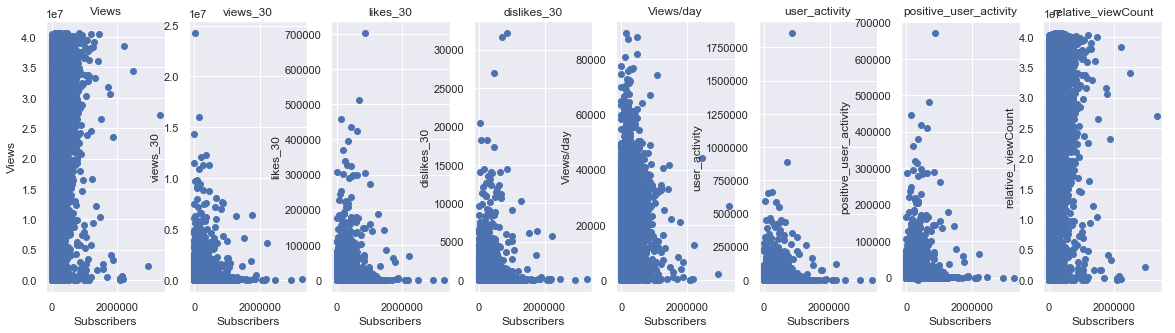

In [47]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    y = final_data_mod2_capped[col]
    x = target
    plt.scatter(x+1, y+1, marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

In [48]:
def normalization(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

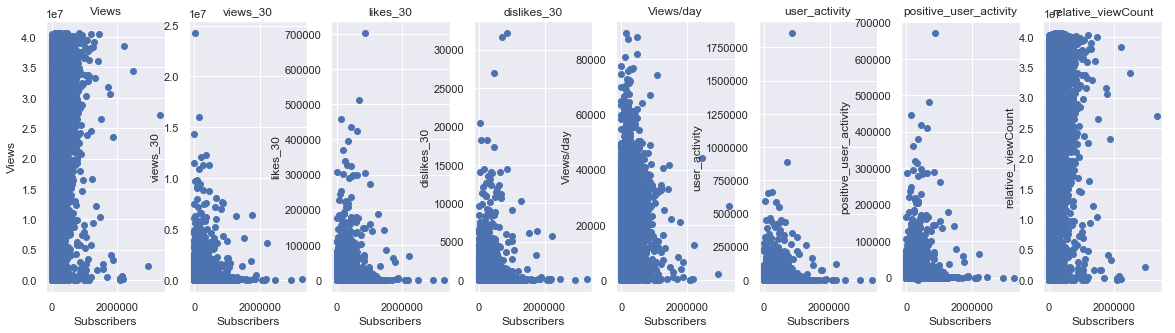

In [49]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = target
    y = final_data_mod2_capped[col]
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

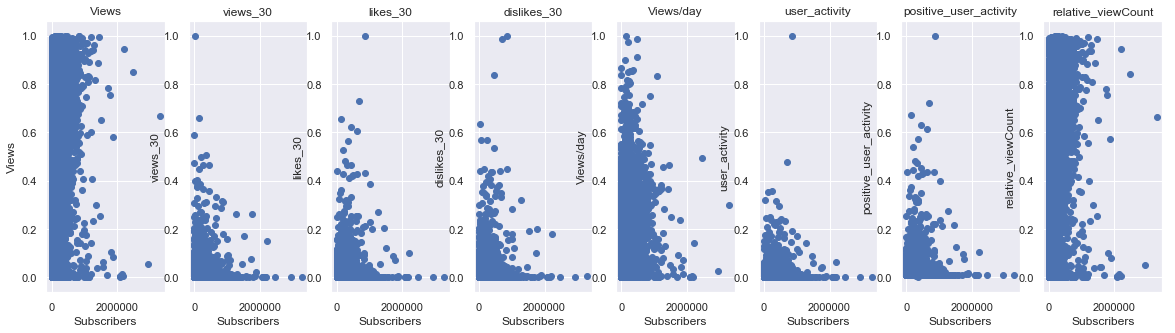

In [50]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = target
    y = final_data_mod2_capped[col]
    plt.scatter(x, normalization(y), marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

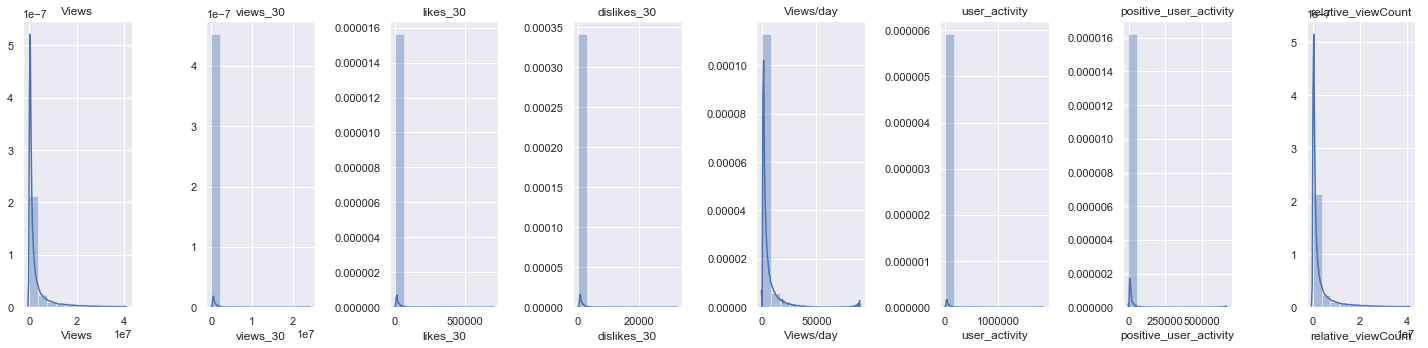

In [51]:
features = final_data_mod2_capped.drop('Subscribers',axis=1).columns
sns.set(rc={'figure.figsize':(20,5)})
fig=plt.figure()
for i,col in enumerate(features):
    ax=fig.add_subplot(1, len(features) , i+1)
    sns.distplot(final_data_mod2_capped[col], bins=11, ax=ax)
    plt.title(col)
fig.tight_layout()    
plt.show()


In [52]:
start=1
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Views'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Views'], final)))
        

1 percentile is 6489
6 percentile is 28768
11 percentile is 67990
16 percentile is 117912
21 percentile is 175275
26 percentile is 243115
31 percentile is 319790
36 percentile is 411551
41 percentile is 519729
46 percentile is 657305
51 percentile is 825878
56 percentile is 1042593
61 percentile is 1335965
66 percentile is 1719555
71 percentile is 2276830
76 percentile is 3089861
81 percentile is 4329913
86 percentile is 6456028
91 percentile is 10371613
96 percentile is 19411305
100 percentile is 40705159


In [53]:
final_data_mod2_capped['views_mod']=(final_data_mod2_capped['Views'])**(1./1.5)

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
final_data_mod2_capped.describe()

,Subscribers,Views,views_30,likes_30,dislikes_30,Views/day,user_activity,positive_user_activity,relative_viewCount,views_mod
count,107396.00,107396.00,107396.00,107396.00,107396.00,107396.00,107396.00,107396.00,107396.00,107396.00
mean,27494.95,3245741.82,25303.61,785.80,38.55,2475.52,1227.37,747.26,3173375.27,16800.85
std,72925.84,6237509.74,243041.40,7671.72,372.92,5467.88,12185.48,7355.35,6145382.68,21271.59
min,0.00,4132.00,0.00,0.00,0.00,0.88,0.00,-6305.00,0.00,257.50
25%,2200.00,228976.00,0.00,0.00,0.00,154.92,0.00,0.00,217990.00,3742.77
50%,5740.00,787730.00,0.00,0.00,0.00,534.31,0.00,0.00,757115.76,8529.40
75%,20300.00,2901127.50,512.00,27.00,1.00,2018.40,55.00,25.00,2809905.75,20341.26
max,3290000.00,40705159.00,24281214.00,703308.00,32180.00,89582.13,1859438.00,671128.00,40685768.66,118331.30


### No significant improvement in data after capping at 5 and 95 %

### After multiple iterations, capping at 5 and 60% improved data distributions and outliers were reduced. But, 60% of data has been lost.

In [55]:
quantiles=final_data_mod2.quantile([0.05, 0.60])

In [56]:
quantiles

,Subscribers,Views,views_30,likes_30,dislikes_30,Views/day,user_activity,positive_user_activity,relative_viewCount
0.05,0.00,4129.00,0.00,0.00,0.00,3.32,0.00,0.00,3438.91
0.60,10000.00,1343983.00,0.00,0.00,0.00,919.33,0.00,0.00,1293751.86


In [57]:
# final_data_mod2_capped=final_data_mod2[(final_data_mod2['Subscribers']>list(quantiles['Subscribers'])[0]) & (final_data_mod2['Subscribers']<list(quantiles['Subscribers'])[1])]

# Capped outliers

In [58]:
final_data_mod2_capped=final_data_mod2[(final_data_mod2['Views']>list(quantiles['Views'])[0]) & (final_data_mod2['Views']<list(quantiles['Views'])[1])]

In [59]:
len(final_data_mod2)-len(final_data_mod2_capped)

53701

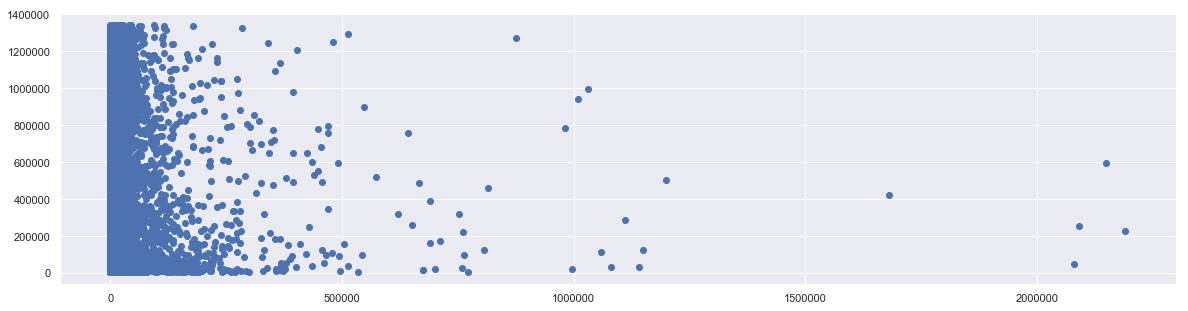

In [60]:
plt.scatter((final_data_mod2_capped['Subscribers']), (final_data_mod2_capped['Views']))

In [61]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Subscribers'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Subscribers'], final)))
        

5 percentile is 0
10 percentile is 1050
15 percentile is 1270
20 percentile is 1460
25 percentile is 1650
30 percentile is 1860
35 percentile is 2080
40 percentile is 2330
45 percentile is 2620
50 percentile is 2960
55 percentile is 3350
60 percentile is 3840
65 percentile is 4430
70 percentile is 5170
75 percentile is 6110
80 percentile is 7430
85 percentile is 9410
90 percentile is 12900
95 percentile is 21200
100 percentile is 2190000


In [62]:
start=5
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Views'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Views'], final)))
        

5 percentile is 13519
10 percentile is 29435
15 percentile is 52268
20 percentile is 79567
25 percentile is 110462
30 percentile is 143607
35 percentile is 180244
40 percentile is 220663
45 percentile is 265568
50 percentile is 312464
55 percentile is 365108
60 percentile is 424501
65 percentile is 490711
70 percentile is 564213
75 percentile is 651401
80 percentile is 750362
85 percentile is 862422
90 percentile is 994857
95 percentile is 1152710
100 percentile is 1343847


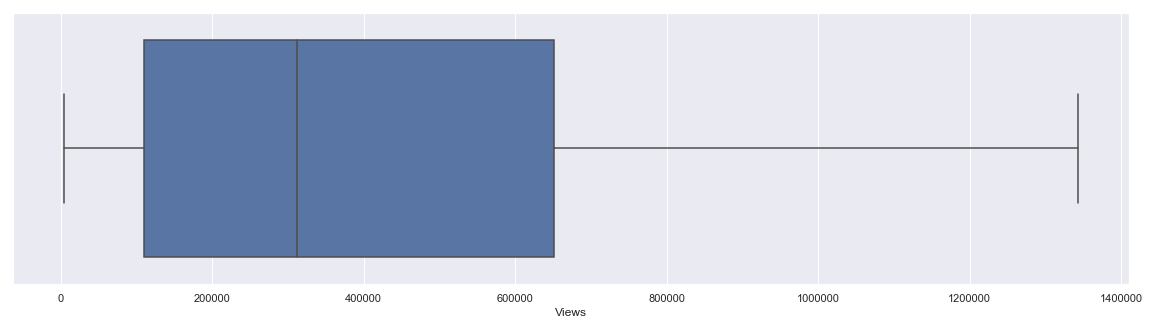

In [63]:
sns.boxplot(x=final_data_mod2_capped['Views'])

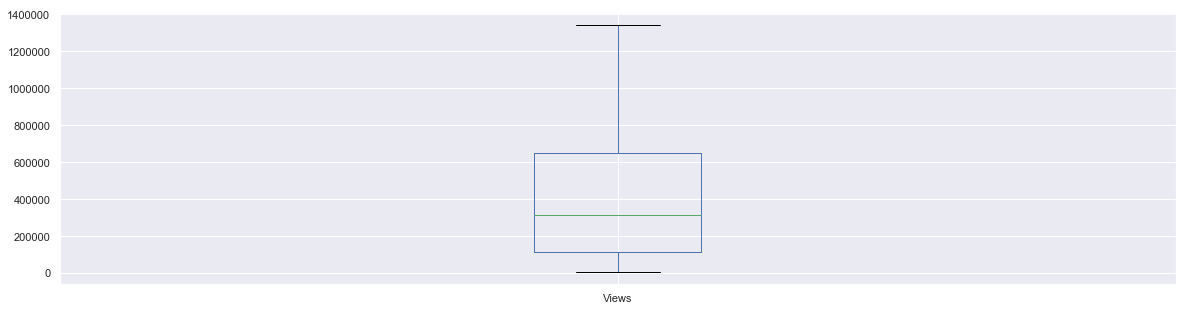

In [64]:
final_data_mod2_capped.boxplot('Views')
plt.show()

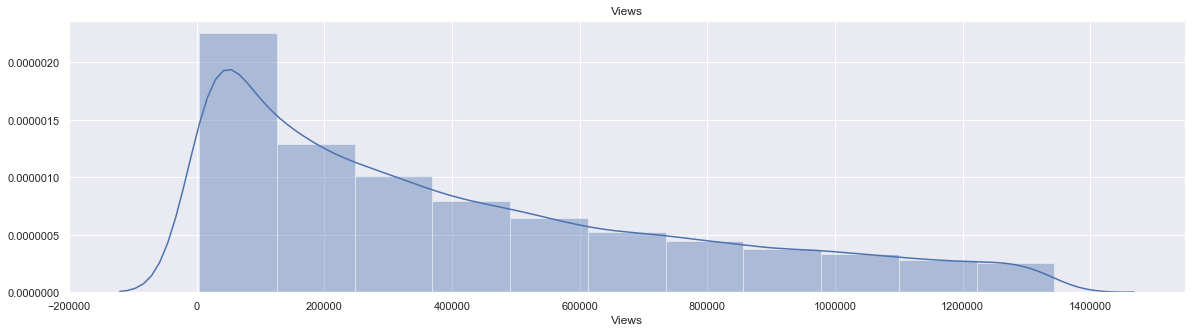

In [65]:
sns.distplot((final_data_mod2_capped['Views']), bins=11)
plt.title('Views')
# fig.tight_layout()    
plt.show()

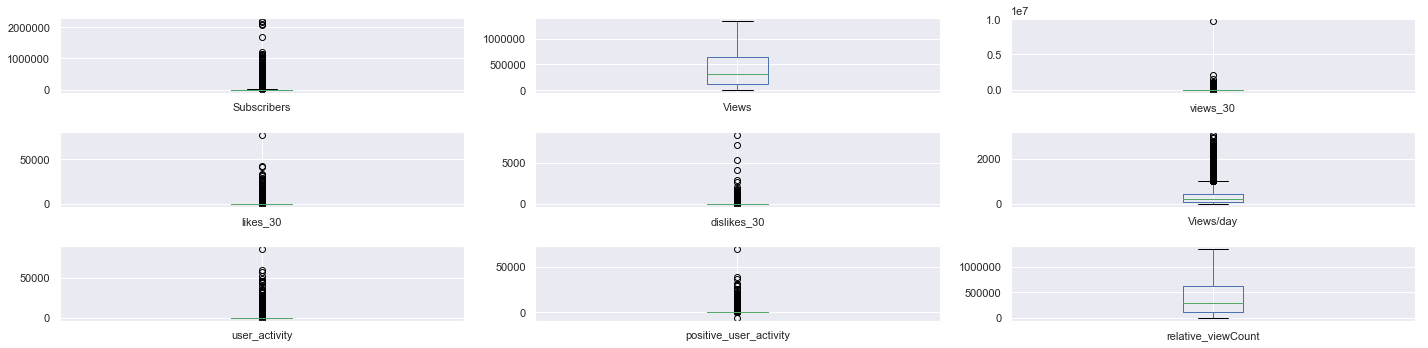

In [66]:
features=final_data_mod2_capped.columns
fig, axes = plt.subplots(3,3)
for i,col in enumerate(list(features)):
    a = final_data_mod2_capped.boxplot(col,  ax=axes.flatten()[i])
# fig.delaxes(axes[1,1])
plt.tight_layout() 
plt.show()

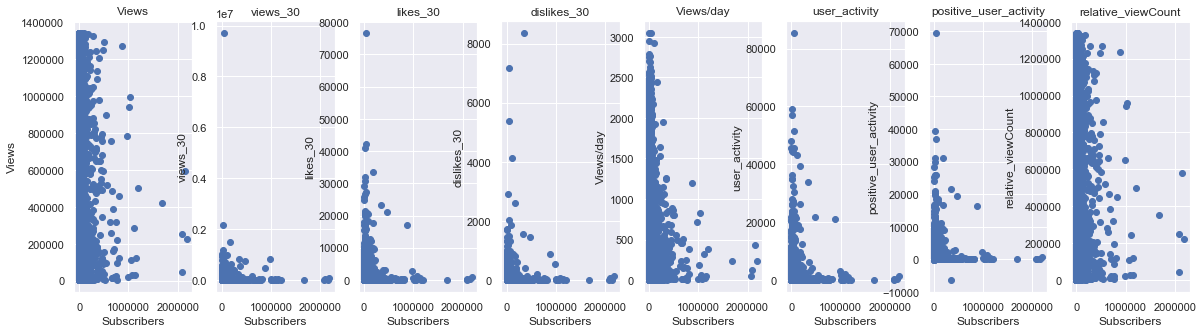

In [67]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    y = final_data_mod2_capped[col]
    x = target
    plt.scatter(x+1, y+1, marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

In [68]:
def normalization(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

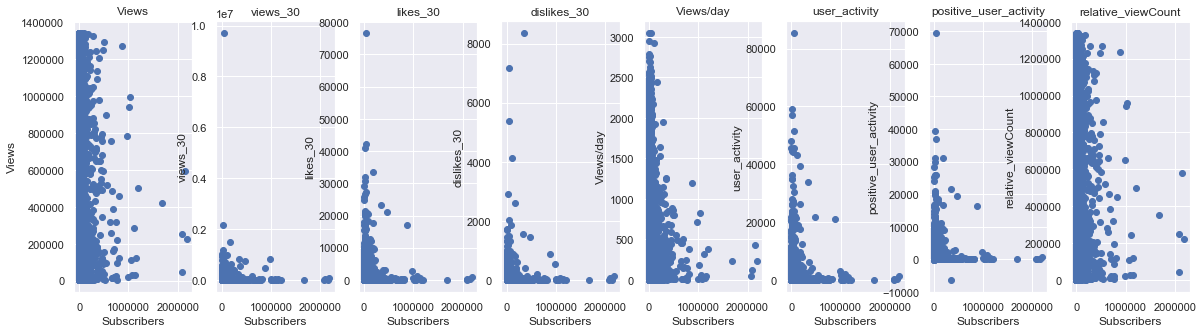

In [69]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = target
    y = final_data_mod2_capped[col]
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

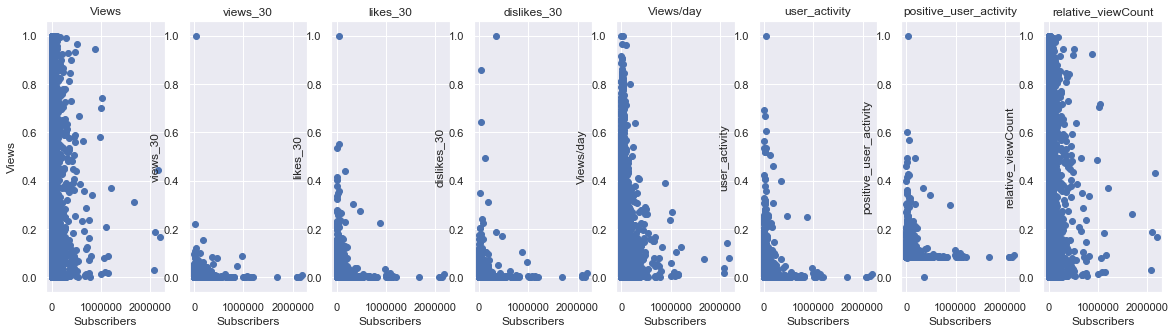

In [70]:
plt.figure(figsize=(20, 5))
features = final_data_mod2_capped.drop('Subscribers', axis=1).columns
target = final_data_mod2_capped['Subscribers']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = target
    y = final_data_mod2_capped[col]
    plt.scatter(x, normalization(y), marker='o')
    plt.title(col)
    plt.xlabel('Subscribers')
    plt.ylabel(col)

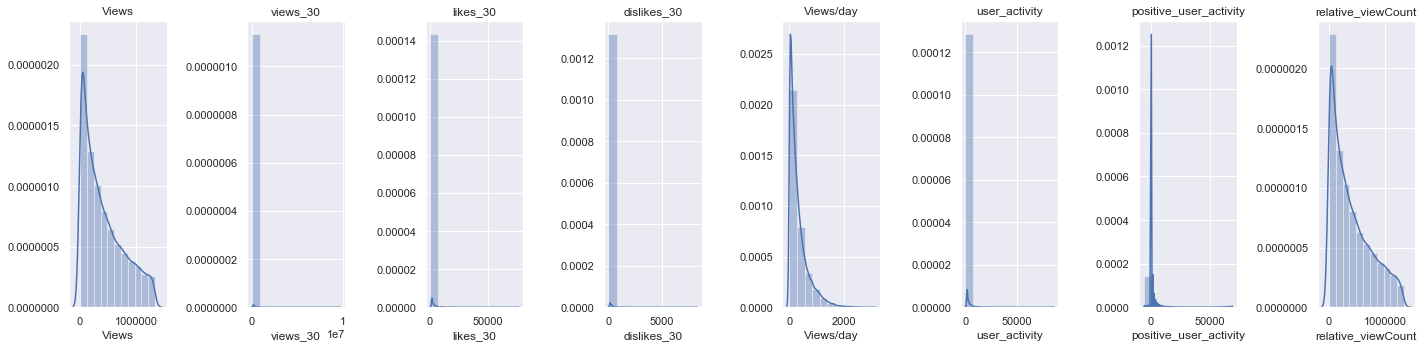

In [71]:
features = final_data_mod2_capped.drop('Subscribers',axis=1).columns
sns.set(rc={'figure.figsize':(20,5)})
fig=plt.figure()
for i,col in enumerate(features):
    ax=fig.add_subplot(1, len(features) , i+1)
    sns.distplot(final_data_mod2_capped[col], bins=11, ax=ax)
    plt.title(col)
fig.tight_layout()    
plt.show()


In [72]:
start=1
end=100
gap=5
final=end
for i in range(start,end,gap):
    print('{} percentile is {}' .format(i, percentile(final_data_mod2_capped['Views'], i)))
print('{} percentile is {}' .format(final, percentile(final_data_mod2_capped['Views'], final)))
        

1 percentile is 5528
6 percentile is 16247
11 percentile is 33572
16 percentile is 57112
21 percentile is 85473
26 percentile is 116751
31 percentile is 150651
36 percentile is 187966
41 percentile is 229713
46 percentile is 274406
51 percentile is 322637
56 percentile is 376015
61 percentile is 437731
66 percentile is 504463
71 percentile is 580834
76 percentile is 671108
81 percentile is 770025
86 percentile is 886341
91 percentile is 1023192
96 percentile is 1188259
100 percentile is 1343847


In [73]:
final_data_mod2_capped['views_mod']=(final_data_mod2_capped['Views'])**(1./1.5)

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
final_data_mod2_capped.describe()

,Subscribers,Views,views_30,likes_30,dislikes_30,Views/day,user_activity,positive_user_activity,relative_viewCount,views_mod
count,65630.00,65630.00,65630.00,65630.00,65630.00,65630.00,65630.00,65630.00,65630.00,65630.00
mean,7543.90,416056.74,2213.26,76.05,4.11,326.60,143.29,71.94,400276.03,5056.24
std,32453.26,361130.19,44193.54,732.39,63.05,351.95,1147.49,690.07,350459.28,3254.00
min,0.00,4132.00,0.00,0.00,0.00,0.88,0.00,-6305.00,0.00,257.50
25%,1650.00,110465.50,0.00,0.00,0.00,77.43,0.00,0.00,104467.26,2302.24
50%,2960.00,312474.50,0.00,0.00,0.00,209.19,0.00,0.00,298887.66,4604.79
75%,6110.00,651387.25,71.00,4.00,0.00,449.22,7.50,4.00,626795.98,7514.37
max,2190000.00,1343847.00,9711084.00,76689.00,8363.00,3048.93,85452.50,69532.00,1340324.03,12177.74


In [75]:
X_train,  X_test, y_train, y_test= train_test_split(final_data_mod2_capped.drop('Subscribers',axis=1), final_data_mod2_capped['Subscribers'].ravel(), test_size=0.2, random_state=42)

In [76]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52504, 9) (13126, 9) (52504,) (13126,)


In [77]:
sc=StandardScaler()

In [78]:
X_train=sc.fit_transform(X_train)

C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [79]:
X_test=sc.transform(X_test)

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [80]:
X_train

array([[ 0.19904058, -0.04641752, -0.10270954, ..., -0.10325103,
         0.20485316,  0.3510737 ],
       [-0.20613936, -0.04641752, -0.10270954, ..., -0.10325103,
        -0.18154988, -0.05195151],
       [ 0.36042248, -0.04641752, -0.10270954, ..., -0.10325103,
         0.41092958,  0.49989656],
       ...,
       [-0.58456632, -0.04641752, -0.10270954, ..., -0.10325103,
        -0.56182699, -0.48569203],
       [-0.7179491 , -0.04641752, -0.10270954, ..., -0.10325103,
        -0.70920088, -0.66058713],
       [-0.36790618, -0.04445306, -0.08895677, ..., -0.08866017,
        -0.35219001, -0.22853282]])

In [81]:
from sklearn.linear_model import LinearRegression

In [82]:
lr=LinearRegression()

In [83]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
y_pred=lr.predict(X_test)

In [85]:
mean_squared_error(y_test, y_pred)

1124086014.8516603

In [86]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
y_test[y_test==0] = 1

In [88]:
MAPE(y_test, y_pred)

47074.19886521174

In [89]:
def error_cal_fun(y_test, y_pred, error_rate):
    error = (y_test*error_rate)/100
    error_5_i = y_test+error
    error_5_d = y_test-error
    cond=[]
    cond=['yes' if (y_pred[x] < error_5_i[x]) and (y_pred[x]>error_5_d[x]) else 'no' for x in range(len(y_pred))]
    lists = len([x for x in cond if x=='yes' ])
    a=print('overall sample size is {}, \nlisted error elements are {}, \nfor error rate {}% deviation, \nwhich is {}% of overall population'.format(len(y_pred), (lists), error_rate, (lists/len(y_pred))))
    return (a) 

### Only 10% of data is within 20% deviation

In [90]:
error_cal_fun(y_test, y_pred,20)

overall sample size is 13126, 
listed error elements are 1299, 
for error rate 20% deviation, 
which is 0.0989638884656407% of overall population


In [91]:
final_data_mod2_capped1=final_data_mod2_capped[:]

### Removing Multicollinearity problem with VIF

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final_data_mod2_capped1.values, i) for i in range(final_data_mod2_capped1.shape[1])]
vif["features"] = final_data_mod2_capped1.columns
vif.round(2)

C:\Users\Acharya\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.06,Subscribers
1,285.14,Views
2,2.37,views_30
3,inf,likes_30
4,inf,dislikes_30
5,4.79,Views/day
6,7.17,user_activity
7,inf,positive_user_activity
8,241.25,relative_viewCount
9,35.72,views_mod


In [93]:
final_data_mod2_capped1.drop(['positive_user_activity'], inplace=True, axis=1)

C:\Users\Acharya\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final_data_mod2_capped1.values, i) for i in range(final_data_mod2_capped1.shape[1])]
vif["features"] = final_data_mod2_capped1.columns
vif.round(2)

,VIF Factor,features
0,1.06,Subscribers
1,285.14,Views
2,2.37,views_30
3,8.81,likes_30
4,2.35,dislikes_30
5,4.79,Views/day
6,7.17,user_activity
7,241.25,relative_viewCount
8,35.72,views_mod


In [95]:
final_data_mod2_capped1.drop(['relative_viewCount'], inplace=True, axis=1)

In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final_data_mod2_capped1.values, i) for i in range(final_data_mod2_capped1.shape[1])]
vif["features"] = final_data_mod2_capped1.columns
vif.round(2)

,VIF Factor,features
0,1.06,Subscribers
1,38.59,Views
2,2.37,views_30
3,8.81,likes_30
4,2.35,dislikes_30
5,4.79,Views/day
6,7.16,user_activity
7,35.69,views_mod


In [97]:
final_data_mod2_capped1.drop(['Views'], inplace=True, axis=1)

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final_data_mod2_capped1.values, i) for i in range(final_data_mod2_capped1.shape[1])]
vif["features"] = final_data_mod2_capped1.columns
vif.round(2)

,VIF Factor,features
0,1.05,Subscribers
1,2.37,views_30
2,8.81,likes_30
3,2.35,dislikes_30
4,4.40,Views/day
5,7.16,user_activity
6,4.42,views_mod


In [99]:
final_data_mod2_capped1.drop(['user_activity'], inplace=True, axis=1)

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(final_data_mod2_capped1.values, i) for i in range(final_data_mod2_capped1.shape[1])]
vif["features"] = final_data_mod2_capped1.columns
vif.round(2)

,VIF Factor,features
0,1.05,Subscribers
1,2.18,views_30
2,2.35,likes_30
3,2.26,dislikes_30
4,4.40,Views/day
5,4.42,views_mod


In [101]:
final_data_mod2_capped1.columns

Index(['Subscribers', 'views_30', 'likes_30', 'dislikes_30', 'Views/day',
       'views_mod'],
      dtype='object')

In [102]:
lr1=LinearRegression()

In [103]:
X_train,  X_test, y_train, y_test= train_test_split(final_data_mod2_capped1.drop('Subscribers',axis=1), final_data_mod2_capped1['Subscribers'].ravel(), test_size=0.2, random_state=42)

In [135]:
lr1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [136]:
y_pred1=lr1.predict(X_test)

In [137]:
mean_squared_error(y_test,y_pred1 )

1124799333.4756336

In [138]:
error_cal_fun(y_test, y_pred1, 20)

overall sample size is 13126, 
listed error elements are 1265, 
for error rate 20% deviation, 
which is 0.0963736096297425% of overall population


In [139]:
rf=RandomForestRegressor()

In [140]:
rf.fit(X_train, y_train)

C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [141]:
rf_y_pred=rf.predict(X_test)

***Random forest imporved a bit, but not significant

In [144]:
error_cal_fun(y_test, rf_y_pred, 20)

overall sample size is 13126, 
listed error elements are 2095, 
for error rate 20% deviation, 
which is 0.1596068870943166% of overall population


In [145]:
final_data_mod1.columns

Index(['Views', 'Uploads', 'views_30', 'likes_30', 'dislikes_30',
       'comments_30', 'duration_30', 'age_ch', 'Views/day', 'Uploads/day',
       'Views/Uploads', 'playlist_count', 'Subscribers',
       'channel_views_per_day', 'user_activity', 'vcbyua',
       'positive_user_activity', 'relative_user_activity',
       'Avg_channel_view_count', 'relative_viewCount'],
      dtype='object')

# Grid searchcv for parameter tuning with Random forest

In [147]:
estimator = RandomForestRegressor()

param_grid = { 
        "n_estimators"      : [10,20,30],
        "max_features"      : ["auto"],
        "min_samples_split" : [2,4,8],
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, verbose=2)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto'], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [148]:
grid_y_pred=grid.predict(X_test)

In [149]:
mean_squared_error(y_test,grid_y_pred)

1173648048.5266392

***Hyperparameter tuning also not significant

In [152]:
error_cal_fun(y_test,grid_y_pred, 20)

overall sample size is 13126, 
listed error elements are 1949, 
for error rate 20% deviation, 
which is 0.1484839250342831% of overall population


### Binning data into muliiple parts and developing models

In [104]:
data1=final_data_mod2_capped1[:]
bins=[0, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000,50000000, 1000000000]
category = pd.cut(data1.Subscribers,bins)
category= category.astype(str).str.strip('()[]').to_frame()
category.columns = ['range']
data1['range']= category
data1.columns

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Subscribers', 'views_30', 'likes_30', 'dislikes_30', 'Views/day',
       'views_mod', 'range'],
      dtype='object')

In [105]:
data1['range']=data1['range'].astype('category')

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [106]:
data1['range'].unique()

[0.0, 500.0, nan, 500.0, 1000.0, 1000.0, 2000.0, 2000.0, 5000.0, ..., 1000000.0, 5000000.0, 500000.0, 1000000.0, 5000.0, 10000.0, 100000.0, 500000.0, 50000.0, 100000.0]
Length: 11
Categories (11, object): [0.0, 500.0, nan, 500.0, 1000.0, 1000.0, 2000.0, ..., 500000.0, 1000000.0, 5000.0, 10000.0, 100000.0, 500000.0, 50000.0, 100000.0]

In [107]:
X_train,  X_test, y_train, y_test= train_test_split(data1.drop(['Subscribers', 'range'],axis=1), data1['range'], test_size=0.2, random_state=42)

### Trying to predict class of range of subscribers using bin value as response

In [108]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)


In [158]:
estimator = RandomForestClassifier()

param_grid = { 
        "n_estimators"      : [10,20,30],
        "max_features"      : ["auto"],
        "min_samples_split" : [2,4,8],
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, verbose=2)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   39.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto'], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [159]:
grid_class_y_pred=grid.predict(X_test)

In [160]:
from sklearn.metrics import accuracy_score

In [161]:
accuracy_score(y_test,grid_class_y_pred)

0.372619229011123

In [109]:
le.classes_

array(['0.0, 500.0', '1000.0, 2000.0', '10000.0, 50000.0',
       '100000.0, 500000.0', '1000000.0, 5000000.0', '2000.0, 5000.0',
       '500.0, 1000.0', '5000.0, 10000.0', '50000.0, 100000.0',
       '500000.0, 1000000.0', 'nan'], dtype=object)

In [110]:
data1['range'].replace('nan','0.0, 1000.0', inplace=True )

C:\Users\Acharya\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [111]:
data2=pd.get_dummies(data1['range'])

In [112]:
data1=pd.concat([data1, data2], axis=1)

In [113]:
data1.head()

,Subscribers,views_30,likes_30,dislikes_30,Views/day,views_mod,range,"0.0, 1000.0","0.0, 500.0","1000.0, 2000.0","10000.0, 50000.0","100000.0, 500000.0","1000000.0, 5000000.0","2000.0, 5000.0","500.0, 1000.0","5000.0, 10000.0","50000.0, 100000.0","500000.0, 1000000.0"
1,137,0,0,0,13.29,411.98,"0.0, 500.0",0,1,0,0,0,0,0,0,0,0,0
2,114,0,0,0,12.22,500.44,"0.0, 500.0",0,1,0,0,0,0,0,0,0,0,0
7,107,0,0,0,5.83,309.50,"0.0, 500.0",0,1,0,0,0,0,0,0,0,0,0
14,93,0,0,0,14.23,401.86,"0.0, 500.0",0,1,0,0,0,0,0,0,0,0,0
15,252,0,0,0,2.55,389.09,"0.0, 500.0",0,1,0,0,0,0,0,0,0,0,0


### Developing multiple models with according to bin values

In [114]:
X_train,  X_test, y_train, y_test= train_test_split(data1.drop(['Subscribers', 'range'],axis=1), data1['Subscribers'], test_size=0.2, random_state=42)

In [172]:
estimator1 = RandomForestRegressor()

param_grid = { 
        "n_estimators"      : [10,20,30],
        "max_features"      : ["auto"],
        "min_samples_split" : [2,4,8],
        }

grid1 = GridSearchCV(estimator1, param_grid, n_jobs=-1, cv=3, verbose=2)

grid1.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto'], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [174]:
grid_regress_y_pred=grid1.predict(X_test)

In [175]:
grid_regress_y_pred

array([ 8152.95938506,  2616.01957071, 20198.40205628, ...,
        1550.63070263,  3071.37615995,  7667.81729692])

### overall model accuracy is at 50%

In [177]:
error_cal_fun(y_test.values, grid_regress_y_pred, 20)

overall sample size is 13126, 
listed error elements are 6498, 
for error rate 20% deviation, 
which is 0.4950479963431358% of overall population


### Models on binned ranges

In [116]:
data3=final_data_mod2_capped1[:]

In [117]:
data3['sub_range']=['low' if x<1000 else 'medium' if x>1000 and x<5000 else 'average' if x>5000 and x<10000 else 'aboveavg' if x>10000 and x<50000 else 'high' if x>50000 and x<100000 else 'extraord' for x in data3['Subscribers']]

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
data3['sub_range']=data3['sub_range'].astype('category')

C:\Users\Acharya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
model1_data=data3[data3['sub_range']=='low']

In [120]:
model2_data=data3[data3['sub_range']=='medium']

In [121]:
model3_data=data3[data3['sub_range']=='average']

In [122]:
model4_data=data3[data3['sub_range']=='aboveavg']

In [123]:
model5_data=data3[data3['sub_range']=='high']

In [124]:
model6_data=data3[data3['sub_range']=='extraord']

# low range

In [125]:
X_train1,  X_test1, y_train1, y_test1= train_test_split(model1_data.drop(['Subscribers', 'sub_range'],axis=1), model1_data['Subscribers'], test_size=0.2, random_state=42)

In [191]:
estimator_lr1=LinearRegression()
estimator_lr1.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [192]:
lr_y_pred1=estimator_lr1.predict(X_test1)

In [193]:
error_cal_fun(y_test1.values, lr_y_pred1, 20)

overall sample size is 1190, 
listed error elements are 44, 
for error rate 20% deviation, 
which is 0.03697478991596639% of overall population


In [194]:
estimator_rf1 = RandomForestRegressor()

estimator_rf1.fit(X_train1, y_train1)


C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [195]:
grid_regress_y_pred1=estimator_rf1.predict(X_test1)

In [196]:
grid_regress_y_pred1

array([ 91. , 299.5,   0. , ..., 610.7,  70. , 224.5])

In [197]:
error_cal_fun(y_test1.values, grid_regress_y_pred1, 20)

overall sample size is 1190, 
listed error elements are 58, 
for error rate 20% deviation, 
which is 0.04873949579831933% of overall population


In [198]:
import xgboost

In [199]:
xg=xgboost.XGBRegressor()

In [200]:
xg.fit(X_train1, y_train1)

C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:23:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [201]:
y_pred_xg1=xg.predict(X_test1)

In [202]:
error_cal_fun(y_test1.values, y_pred_xg1, 20)

overall sample size is 1190, 
listed error elements are 56, 
for error rate 20% deviation, 
which is 0.047058823529411764% of overall population


## medium range

In [203]:
X_train2,  X_test2, y_train2, y_test2= train_test_split(model2_data.drop(['Subscribers', 'sub_range'],axis=1), model2_data['Subscribers'], test_size=0.2, random_state=42)

In [204]:
estimator_rf2 = RandomForestRegressor()

estimator_rf2.fit(X_train2, y_train2)


C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [205]:
grid_regress_y_pred2=estimator_rf2.predict(X_test2)

In [206]:
grid_regress_y_pred2

array([1844., 2417., 2842., ..., 2121., 1918., 2184.])

In [207]:
error_cal_fun(y_test2.values, grid_regress_y_pred2, 20)

overall sample size is 7844, 
listed error elements are 2585, 
for error rate 20% deviation, 
which is 0.32955124936257013% of overall population


In [208]:
xg.fit(X_train2, y_train2)

[13:23:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [209]:
y_pred_xg2=xg.predict(X_test2)

In [210]:
error_cal_fun(y_test2.values, y_pred_xg2, 20)

overall sample size is 7844, 
listed error elements are 2632, 
for error rate 20% deviation, 
which is 0.3355430902600714% of overall population


### average range

In [211]:
X_train3,  X_test3, y_train3, y_test3= train_test_split(model3_data.drop(['Subscribers', 'sub_range'],axis=1), model3_data['Subscribers'], test_size=0.2, random_state=42)

In [212]:
estimator_rf3 = RandomForestRegressor()

estimator_rf3.fit(X_train3, y_train3)


C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [213]:
grid_regress_y_pred3=estimator_rf3.predict(X_test3)

In [214]:
grid_regress_y_pred3

array([7272., 6551., 7224., ..., 6760., 7255., 6075.])

In [215]:
error_cal_fun(y_test3.values, grid_regress_y_pred3, 20)

overall sample size is 2241, 
listed error elements are 1291, 
for error rate 20% deviation, 
which is 0.5760821062025882% of overall population


In [216]:
xg.fit(X_train3, y_train3)

[13:24:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [217]:
y_pred_xg3=xg.predict(X_test3)

In [218]:
error_cal_fun(y_test3.values, y_pred_xg3, 20)

overall sample size is 2241, 
listed error elements are 1311, 
for error rate 20% deviation, 
which is 0.5850066934404283% of overall population


#### above average range

In [219]:
X_train4,  X_test4, y_train4, y_test4= train_test_split(model4_data.drop(['Subscribers', 'sub_range'],axis=1), model4_data['Subscribers'], test_size=0.2, random_state=42)

In [220]:
estimator_rf4 = RandomForestRegressor()

estimator_rf4.fit(X_train4, y_train4)

C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [221]:
grid_regress_y_pred4=estimator_rf4.predict(X_test4)

In [222]:
grid_regress_y_pred4

array([17090., 20130., 16040., ..., 16150., 12460., 20830.])

In [223]:
error_cal_fun(y_test4.values, grid_regress_y_pred4, 20)

overall sample size is 1590, 
listed error elements are 531, 
for error rate 20% deviation, 
which is 0.3339622641509434% of overall population


In [224]:
xg.fit(X_train4, y_train4)

[13:24:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [225]:
y_pred_xg4=xg.predict(X_test4)

In [226]:
error_cal_fun(y_test4.values, y_pred_xg4, 20)

overall sample size is 1590, 
listed error elements are 494, 
for error rate 20% deviation, 
which is 0.31069182389937106% of overall population


#### high range

In [227]:
X_train5,  X_test5, y_train5, y_test5= train_test_split(model5_data.drop(['Subscribers', 'sub_range'],axis=1), model5_data['Subscribers'], test_size=0.2, random_state=52)

In [228]:
estimator_rf5 = RandomForestRegressor()

estimator_rf5.fit(X_train5, y_train5)

C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [229]:
grid_regress_y_pred5=estimator_rf5.predict(X_test5)

In [230]:
grid_regress_y_pred5

array([78270., 81290., 79750., 68110., 84040., 74430., 69730., 74510.,
       70390., 72790., 79280., 83660., 65370., 61410., 68070., 76190.,
       69820., 75370., 55440., 60470., 59040., 65210., 90320., 54600.,
       56270., 71040., 66010., 62090., 66780., 86380., 73540., 52690.,
       72310., 75990., 81970., 68080., 60950., 65830., 69210., 81040.,
       65640., 66280., 68000., 80900., 70780., 83160., 59910., 61070.,
       65660., 67780., 79750., 53820., 83650., 74340., 82590., 65100.,
       60110., 58350., 85200., 67010., 62030., 67970., 74540., 60210.,
       62260., 65350., 56440., 75820., 61280., 55200., 64240., 72530.,
       67930., 58870., 68470., 65940., 82460., 68820., 66380., 65590.,
       74940., 74950., 68510., 58550., 62870., 63880., 66850., 75960.,
       68130., 72720., 57930., 57530., 65880., 86880., 65460., 78780.,
       63480., 66440., 60190., 73210., 75140., 72690., 67420., 63900.,
       88650., 79600., 80800., 83590., 60950., 79980., 85070., 69390.,
      

In [231]:
error_cal_fun(y_test5.values, grid_regress_y_pred5, 20)

overall sample size is 115, 
listed error elements are 66, 
for error rate 20% deviation, 
which is 0.5739130434782609% of overall population


In [232]:
xg=xgboost.XGBRegressor()

In [233]:
xg.fit(X_train5, y_train5)

[13:24:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [234]:
y_pred_xg5=xg.predict(X_test5)

In [235]:
error_cal_fun(y_test5.values, y_pred_xg5, 20)

overall sample size is 115, 
listed error elements are 64, 
for error rate 20% deviation, 
which is 0.5565217391304348% of overall population


#### extraord range

In [236]:
X_train6,  X_test6, y_train6, y_test6= train_test_split(model6_data.drop(['Subscribers', 'sub_range'],axis=1), model6_data['Subscribers'], test_size=0.2, random_state=62)

In [237]:
estimator_rf6 = RandomForestRegressor()

estimator_rf6.fit(X_train6, y_train6)

C:\Users\Acharya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [238]:
grid_regress_y_pred6=estimator_rf6.predict(X_test6)

In [239]:
grid_regress_y_pred6

array([218900.,  83500., 115700.,  93800., 100900., 142200., 162800.,
       236700.,  99200., 845200., 101500., 184500.,  77800., 306500.,
       103900.,  25800., 181700., 232000., 239700., 123200., 260400.,
       212700., 166300.,  91100., 254800.,  97100., 263700.,  97400.,
       253000., 169200., 416100.,  48400., 174900., 314900., 130400.,
        36700., 450200., 155300.,  85600., 263600., 161900., 189900.,
       306700., 125200., 188800., 158000., 120700.,  87600., 111900.,
       213500., 132800., 343300., 443400., 225900., 115500.,  74000.,
       106200., 108600., 302700., 102600.,  80600., 161200.,  87200.,
        55300., 296900., 185700., 334800., 276100.,  91100., 234700.,
       201500., 174400., 111800., 135700., 462000., 209000., 106900.,
       158200., 140900.,  57400.,  33100., 233400., 166700., 110300.,
        75100., 319300., 361700., 216500., 229200., 100000., 151100.,
       195800., 138400., 154200.,  97800., 498400.,  69900.,  63800.,
       100500., 1159

In [240]:
error_cal_fun(y_test6.values, grid_regress_y_pred6, 20)

overall sample size is 147, 
listed error elements are 17, 
for error rate 20% deviation, 
which is 0.11564625850340136% of overall population


In [241]:
xg=xgboost.XGBRegressor()

In [242]:
xg.fit(X_train6, y_train6)

[13:24:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Acharya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [243]:
y_pred_xg6=xg.predict(X_test6)

In [244]:
error_cal_fun(y_test6.values, y_pred_xg6, 20)

overall sample size is 147, 
listed error elements are 20, 
for error rate 20% deviation, 
which is 0.1360544217687075% of overall population
